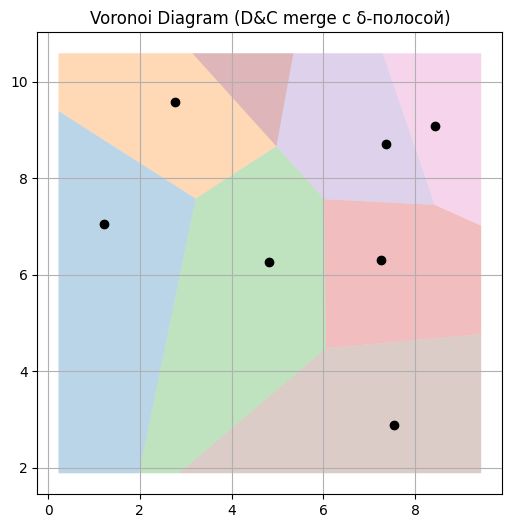

In [ ]:
import numpy as np
from collections import defaultdict

# помощь для полуплоскости
def bisector(p1, p2):
    mid = (p1 + p2) / 2
    dx, dy = p2 - p1
    A, B = dx, dy
    C = A * mid[0] + B * mid[1]
    return A, B, C

def clip_polygon(poly, A, B, C):
    new_poly = []
    for i in range(len(poly)):
        P, Q = poly[i], poly[(i+1)%len(poly)]
        inP = A*P[0] + B*P[1] <= C
        inQ = A*Q[0] + B*Q[1] <= C
        if inP: 
            new_poly.append(P)
        if inP ^ inQ: # if (inP and not inQ) or (not inP and inQ)
            denom = A*(Q[0]-P[0]) + B*(Q[1]-P[1])
            if abs(denom)<1e-9: 
                continue
            t = (C - (A*P[0]+B*P[1]))/denom
            new_poly.append(P + t*(Q-P))
    return np.array(new_poly)

class VoronoiCell:
    def __init__(self, site, polygon):
        self.site = site
        self.polygon = polygon

def voronoi_divide_and_conquer(points, bbox):
    n = len(points)
    if n==1:
        return [VoronoiCell(points[0], bbox.copy())]
    if n==2:
        A,B,C = bisector(points[0], points[1])
        return [
            VoronoiCell(points[0], clip_polygon(bbox.copy(),  A,  B,  C)),
            VoronoiCell(points[1], clip_polygon(bbox.copy(), -A, -B, -C))
        ]

    # 1) разделяем по X
    order = np.argsort(points[:,0])
    pts = points[order]
    mid = n//2
    left_pts, right_pts = pts[:mid], pts[mid:]
    mid_x = pts[mid][0]

    # 2) рекурсивно строим
    left_cells  = voronoi_divide_and_conquer(left_pts,  bbox)
    right_cells = voronoi_divide_and_conquer(right_pts, bbox)

    # 3) считаем минимальный кросс-distance δ между левыми и правыми сайтами
    left_sites  = np.array([c.site for c in left_cells])
    right_sites = np.array([c.site for c in right_cells])
    δ = np.min([np.linalg.norm(p-q)
                for p in left_sites
                for q in right_sites])

    merged = []
    # 4) сшиваем: для каждой ячейки клипаем только «ближайшие» соседи из другой половины
    for cell in left_cells + right_cells:
        poly = cell.polygon.copy()
        site = cell.site
        # выбираем, из какой половины брать «others»
        if any(np.all(site==p) for p in left_sites):
            cand = right_sites
            # оставляем только те s, что в полосе [mid_x-δ, mid_x+δ]
            cand = [s for s in cand
                    if abs(s[0] - mid_x) < δ]
        else:
            cand = left_sites
            cand = [s for s in cand
                    if abs(s[0] - mid_x) < δ]

        # «дозакрываем» полигон полуплоскостями от этих кандидатов
        for s in cand:
            A,B,C = bisector(site, s)
            # убеждаемся, что оставляем ту сторону, где наш site
            if (A*s[0] + B*s[1]) < (A*site[0] + B*site[1]):
                A,B,C = -A, -B, -C
            poly = clip_polygon(poly, A, B, C)
            if poly.size==0:
                break

        merged.append(VoronoiCell(site, poly))

    return merged

# пример использования:
if __name__=='__main__':
    import matplotlib.pyplot as plt
    # рандомные 7 точек
    pts = np.random.rand(7,2)*10
    # bounding box
    mn, mx = pts.min(axis=0)-1, pts.max(axis=0)+1
    bbox = np.array([[mn[0],mn[1]],[mn[0],mx[1]],[mx[0],mx[1]],[mx[0],mn[1]]])

    cells = voronoi_divide_and_conquer(pts, bbox)

    # рисуем
    plt.figure(figsize=(6,6))
    for c in cells:
        poly = c.polygon
        if len(poly)>0:
            plt.fill(poly[:,0], poly[:,1], alpha=0.3)
    plt.scatter(pts[:,0], pts[:,1], color='black', zorder=5)
    plt.title("Voronoi Diagram (D&C merge с δ-полосой)")
    plt.grid(True)
    plt.show()
